<a href="https://colab.research.google.com/github/AnshulRanjan2004/NLP/blob/main/Quora_classification_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [2]:
import os

In [3]:
IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

In [4]:
if IS_KAGGLE:
    data_dir = '../input/quora-insincere-questions-classification'
    train_fname = data_dir + '/train.csv'
    test_fname = data_dir + '/test.csv'
    sub_fname = data_dir + '/sample_submission.csv'
else:
    os.environ['KAGGLE_CONFIG_DIR'] = '.'
    !kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p data
    !kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p data
    !kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv -p data
    train_fname = 'data/train.csv.zip'
    test_fname = 'data/test.csv.zip'
    sub_fname = 'data/sample_submission.csv.zip' 

 89% 49.0M/54.9M [00:00<00:00, 84.0MB/s]
100% 54.9M/54.9M [00:00<00:00, 82.0MB/s]
 63% 10.0M/15.8M [00:00<00:00, 46.1MB/s]
100% 15.8M/15.8M [00:00<00:00, 66.9MB/s]
  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 74.7MB/s]


In [5]:
import pandas as pd

In [6]:
raw_df = pd.read_csv(train_fname)
test_df = pd.read_csv(test_fname)
sub_df = pd.read_csv(sub_fname)

In [7]:
raw_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [8]:
test_df

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?
...,...,...
375801,ffff7fa746bd6d6197a9,How many countries listed in gold import in in...
375802,ffffa1be31c43046ab6b,Is there an alternative to dresses on formal p...
375803,ffffae173b6ca6bfa563,Where I can find best friendship quotes in Tel...
375804,ffffb1f7f1a008620287,What are the causes of refraction of light?


In [9]:
sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [10]:
if IS_KAGGLE:
    sample_df = raw_df
else:
    sample_df = raw_df.sample(100_000, random_state=42)

In [11]:
sample_df.target.value_counts(normalize=True)

0    0.93962
1    0.06038
Name: target, dtype: float64

## Prepare Data for Training


Outline:
- Convert text to TF-IDF Vectors
- Split training & validation set
- Convert to PyTorch tensors

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
stemmer = SnowballStemmer(language='english')

def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text)]

In [15]:
tokenize("Ain't nothin' (but a heartache)!")

['ai', "n't", 'nothin', "'", '(', 'but', 'a', 'heartach', ')', '!']

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
english_stopwords = stopwords.words('english')

In [19]:
vectorizer = TfidfVectorizer(lowercase=True, 
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1000)

In [20]:
%%time
vectorizer.fit(sample_df.question_text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 31 s, sys: 66.7 ms, total: 31.1 s
Wall time: 33.1 s


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7f01bb91aef0>)

In [21]:
%%time
inputs = vectorizer.transform(sample_df.question_text)

CPU times: user 29.6 s, sys: 34.9 ms, total: 29.6 s
Wall time: 29.8 s


In [22]:
inputs.shape

(100000, 1000)

In [23]:
targets = sample_df.target.values

In [24]:
targets.shape

(100000,)

In [25]:
%%time
test_inputs = vectorizer.transform(test_df.question_text)

CPU times: user 1min 57s, sys: 250 ms, total: 1min 57s
Wall time: 2min 9s


### Split training and validation set

In [26]:
from sklearn.model_selection import train_test_split

In [50]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size=0.3, random_state=42)

In [47]:
train_inputs.shape, val_inputs.shape

((70000, 1000), (30000, 1000))

In [49]:
train_targets.shape

(70000,)

### Convert to PyTorch Tensors

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [51]:
train_tensors = F.normalize(torch.tensor(train_inputs.toarray()).float(), dim=0)
val_tensors = F.normalize(torch.tensor(val_inputs.toarray()).float(), dim=0)

In [52]:
train_tensors.shape, val_tensors.shape

(torch.Size([70000, 1000]), torch.Size([30000, 1000]))

In [53]:
train_ds = TensorDataset(train_tensors, torch.tensor(train_targets))
val_ds = TensorDataset(val_tensors, torch.tensor(val_targets))

In [54]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [55]:
for inputs_batch, targets_batch in train_dl:
    print('inputs.shape', inputs_batch.shape)
    print('targets.shape', targets_batch.shape)
    print(targets_batch)
    break

inputs.shape torch.Size([128, 1000])
targets.shape torch.Size([128])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])


## Logistic Regression Model

In [56]:
import torch.nn as nn

In [58]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1000, 1)
        
    def forward(self, xb):
        out = self.linear1(xb)
        return out

In [59]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [60]:
logreg_model = LogReg()

In [61]:
for batch in val_dl:
    batch_inputs, batch_targets = batch
    print('inputs.shape', batch_inputs.shape)
    print('targets', batch_targets)
    
    batch_out = logreg_model(batch_inputs)
    probs = torch.sigmoid(batch_out[:,0])
    preds = (probs >= 0.5).int()
    
    print('outputs', preds)
    print('accuracy', accuracy_score(batch_targets, preds))
    print('f1_score', f1_score(batch_targets, preds))
    break

inputs.shape torch.Size([128, 1000])
targets tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0])
outputs tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
accuracy 0.0625
f1_score 0.11764705882352941


In [64]:
def evaluate(model, dl):
    losses, accs, f1s = [], [], []
    for batch in dl:
        inputs, targets = batch
        out = model(inputs)
        
        probs = torch.sigmoid(out[:,0])
        loss = F.binary_cross_entropy(probs, targets.float(), weight=torch.tensor(20.))
        losses.append(loss.item())

        preds = (probs > 0.5).int()
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds)
        
        accs.append(acc)
        f1s.append(f1)

    return np.mean(losses), np.mean(accs), np.mean(f1s)

In [65]:
def fit(epochs, lr, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            inputs, targets = batch
            out = model(inputs)
            probs = torch.sigmoid(out[:,0])
            loss = F.binary_cross_entropy(probs, 
                                          targets.float(), 
                                          weight=torch.tensor(20.))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        loss, acc, f1 = result
        print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 Score: {:.4f}'.format(
            epoch, loss, acc, f1))
        history.append(result)

    return history

In [63]:
logreg_model = LogReg()

In [66]:
history = [evaluate(logreg_model, val_dl)]

In [67]:
history

[(13.96533574855074, 0.06073803191489362, 0.11369495437720041)]

In [69]:
history += fit(5, 0.01, logreg_model, train_dl, val_dl)

Epoch: 0; Loss: 3.2727; Accuracy: 0.9408; F1 Score: 0.0773
Epoch: 1; Loss: 3.1922; Accuracy: 0.9425; F1 Score: 0.1594
Epoch: 2; Loss: 3.1293; Accuracy: 0.9432; F1 Score: 0.2100
Epoch: 3; Loss: 3.0805; Accuracy: 0.9445; F1 Score: 0.2658
Epoch: 4; Loss: 3.0641; Accuracy: 0.9454; F1 Score: 0.3237


In [70]:
history += fit(5, 0.01, logreg_model, train_dl, val_dl)

Epoch: 0; Loss: 3.0653; Accuracy: 0.9464; F1 Score: 0.3759
Epoch: 1; Loss: 3.0626; Accuracy: 0.9462; F1 Score: 0.3994
Epoch: 2; Loss: 3.0369; Accuracy: 0.9461; F1 Score: 0.4026
Epoch: 3; Loss: 3.0398; Accuracy: 0.9460; F1 Score: 0.4146
Epoch: 4; Loss: 3.0548; Accuracy: 0.9459; F1 Score: 0.4290


In [71]:
history += fit(5, 0.01, logreg_model, train_dl, val_dl)

Epoch: 0; Loss: 3.0799; Accuracy: 0.9458; F1 Score: 0.4458
Epoch: 1; Loss: 3.1043; Accuracy: 0.9456; F1 Score: 0.4569
Epoch: 2; Loss: 3.0836; Accuracy: 0.9460; F1 Score: 0.4583
Epoch: 3; Loss: 3.1031; Accuracy: 0.9453; F1 Score: 0.4630
Epoch: 4; Loss: 3.1251; Accuracy: 0.9450; F1 Score: 0.4693


In [72]:
losses = [item[0] for item in history]

In [73]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss')

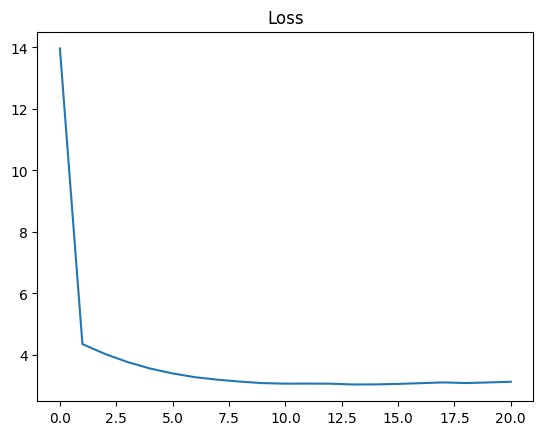

In [74]:
plt.plot(losses);
plt.title('Loss')

In [75]:
f1s = [item[2] for item in history]

Text(0.5, 1.0, 'F1 Score')

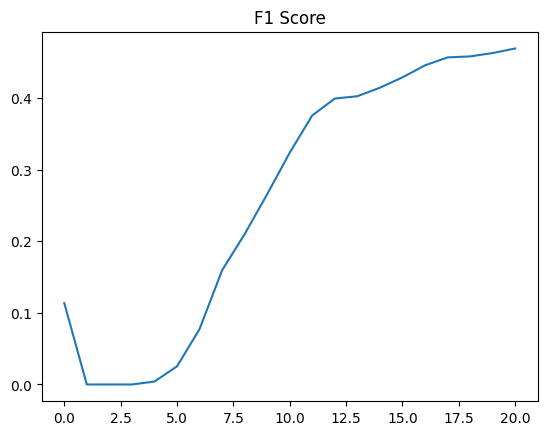

In [76]:
plt.plot(f1s)
plt.title('F1 Score')

## Feed Forward Neural Network

In [77]:
import torch.nn.functional as F

In [78]:
class FeedForwardModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1000, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 1)
        
    def forward(self, xb):
        out = F.relu(self.linear1(xb))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        return out

In [79]:
ff_model = FeedForwardModel()

In [80]:
history = [evaluate(ff_model, val_dl)]

In [81]:
history

[(14.000962159988728, 0.06073803191489362, 0.11375188015022653)]

In [82]:
%%time
history += fit(5, 0.001, ff_model, train_dl, val_dl)

Epoch: 0; Loss: 3.1693; Accuracy: 0.9387; F1 Score: 0.4615
Epoch: 1; Loss: 3.2265; Accuracy: 0.9357; F1 Score: 0.4893
Epoch: 2; Loss: 3.4078; Accuracy: 0.9287; F1 Score: 0.4897
Epoch: 3; Loss: 3.2476; Accuracy: 0.9365; F1 Score: 0.4949
Epoch: 4; Loss: 3.5283; Accuracy: 0.9284; F1 Score: 0.4910
CPU times: user 3min 28s, sys: 208 ms, total: 3min 28s
Wall time: 3min 37s


## Make Predictions and Submit

In [83]:
test_tensors = torch.tensor(test_inputs.toarray()).float()

In [84]:
test_ds = TensorDataset(test_tensors)

In [85]:
test_dl = DataLoader(test_ds, batch_size)

In [86]:
def predict(model, dl):
    all_preds = []
    for batch in dl:
        inputs, = batch
        out = model(inputs)
        probs = torch.sigmoid(out)[:,0]
        preds = (probs > 0.5).int()
        all_preds += list(preds.numpy())
    return all_preds

In [87]:
test_preds = predict(ff_model, test_dl)

In [88]:
test_preds[:20]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

In [89]:
sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [90]:
sub_df.prediction = test_preds

In [91]:
sub_df.to_csv('submission.csv', index=None)

In [92]:
!head submission.csv

qid,prediction
0000163e3ea7c7a74cd7,1
00002bd4fb5d505b9161,0
00007756b4a147d2b0b3,0
000086e4b7e1c7146103,0
0000c4c3fbe8785a3090,1
000101884c19f3515c1a,0
00010f62537781f44a47,0
00012afbd27452239059,0
00014894849d00ba98a9,1
